In [1]:
#Align and crop face
import cv2
import pandas as pd
from helpers.face import Face
from helpers.image_reader import read_image
from preprocessors.asymmetry_calculator import process_all_face

group_directories = {'PD','HC'}
group_directory = 'PD'
output_signal_folder = f'./data/working/csv-signal/'
version = 'v3'


In [2]:
from helpers.load_data_subject_csv import create_dataset
parkinson_df, control_df = create_dataset(output_signal_folder, 'PD', 'HC')
data = pd.concat([parkinson_df, control_df], axis=0)
data = data.sample(frac=1,random_state=8)
#Create dataset for train
data = data.set_index('user')
X = data.drop(['label'], axis=1)
y = data['label']
X = X.fillna(method='bfill')

C:\Users\atefe\AppData\Local\Temp\ipykernel_75876\1924685959.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill')


In [57]:
import joblib
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from helpers.feature_selection import select_features_PCA, select_features_RFE


#X = X.filter(regex='^(mean|variance|amplitude|standard_deviation|rms|kurtosis|skewness|max|median)_')

X_scaled = StandardScaler().fit_transform(X)
selector = RFECV(estimator=LogisticRegression(), step=1, cv=5)
#selector = RFE(estimator=LogisticRegression(), n_features_to_select=25)
X_selected = selector.fit_transform(X_scaled, y)
selected_features_mask = selector.support_
selected_feature_names = X.columns[selected_features_mask]

model_placeholder = Pipeline([
    ('model', LogisticRegression())  # Placeholder for the model
])

# Define the parameter grid
param_grid = [
    # Logistic Regression
    {
        'model': [LogisticRegression(max_iter=10000)],
        'model__C': [0.1, 1,10],
    },
    # Random Forest Classifier
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 200],
        'model__max_features': ['log2', 'sqrt'],
    },
    #SVC
    {
        'model': [SVC()],
        'model__C': [0.1,0.5, 1,2, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    #DecisionTreeClassifier
    {
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [5,10,15],
    },
    # XGBoost Classifier
    {
        'model': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'model__n_estimators': [200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [4],
        'model__subsample': [0.8],  # Subsample ratio of the training instances
        'model__colsample_bytree': [0.9],  # Subsample ratio of columns when constructing each tree
    },
    
]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(model_placeholder, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_selected, y)
# Now, to access the best estimator and its parameters:
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 23 candidates, totalling 115 fits
Best parameters: {'model': LogisticRegression(max_iter=10000), 'model__C': 10}
Best Score: 0.9142307692307693
Accuracy on Test Set: 1.0


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Assuming X_train, X_test, y_train, y_test are already defined as per your code

best_model.fit(X_train, y_train)
# Use the best_model to make predictions on the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print(report)
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

In [50]:
selected_feature_names

Index(['mean_whole_norm', 'variance_whole_norm',
       'standard_deviation_whole_norm', 'rms_whole_norm',
       'standard_deviation_whole_vertically', 'rms_whole_vertically',
       'amplitude_asymmetry_norm_line', 'variance_asymmetry_norm_line',
       'kurtosis_asymmetry_norm_line', 'amplitude_asymmetry_vertically_line',
       'mean_asymmetry_vertically_line',
       'standard_deviation_asymmetry_vertically_line',
       'rms_asymmetry_vertically_line', 'amplitude_asymmetry_norm_eye',
       'standard_deviation_asymmetry_norm_eye', 'mean_asymmetry_norm_eyebrow',
       'mean_asymmetry_norm_mouth', 'rms_asymmetry_norm_mouth',
       'amplitude_asymmetry_vertically_mouth',
       'variance_asymmetry_vertically_mouth',
       'skewness_asymmetry_vertically_mouth', 'variance_asymmetry_norm_nose',
       'mean_asymmetry_vertically_nose',
       'standard_deviation_asymmetry_vertically_nose',
       'kurtosis_asymmetry_vertically_nose'],
      dtype='object')

In [51]:
#grid_search.cv_results_
best_index = grid_search.best_index_
fold_accuracies = grid_search.cv_results_[f'split0_test_score'][best_index], \
                  grid_search.cv_results_[f'split1_test_score'][best_index], \
                  grid_search.cv_results_[f'split2_test_score'][best_index], \
                  grid_search.cv_results_[f'split3_test_score'][best_index], \
                  grid_search.cv_results_[f'split4_test_score'][best_index]

print("Accuracies of the best model on each CV fold:", fold_accuracies)
std_of_best_score = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Standard Deviation of Best Score:", std_of_best_score)

Accuracies of the best model on each CV fold: (0.85, 0.625, 0.825, 0.8461538461538461, 0.7435897435897436)
Standard Deviation of Best Score: 0.08559322326275345


In [59]:
#Save the model
joblib.dump(selected_feature_names, f'models/selected_features_{version}.pkl')
joblib.dump(best_model , f'models/best_model_{version}.pkl')

['models/best_model_v3.pkl']

In [81]:
# Predict on the test set using the best model
y_pred = best_model.predict(X_selected)

# Calculate and print the accuracy on the test set
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

Accuracy on Test Set: 1.0


In [82]:
import numpy as np
indexes = np.where(y_pred != y)
#print user column of y_test where the prediction is wrong
y.iloc[indexes]


Series([], Name: label, dtype: int64)

In [17]:
# Extract columns that include the name 'mean'
from scipy import stats


mean_columns = data.filter(regex='^(amplitude)_')
# Prepare for statistical analysis
results = {}

for column in mean_columns.columns:
    # Splitting the data based on label
    group_0 = data[data['label'] == 0][column]
    group_1 = data[data['label'] == 1][column]
    
    # Perform a t-test to see if there's a significant difference between the two groups
    # Note: This assumes the data is normally distributed and the variances are equal
    # For non-normal data, consider using Mann-Whitney U test instead
    stat, p_value = stats.ttest_ind(group_0, group_1)
    
    # Store the result
    if(p_value < 0.05):
        results[column] = p_value

#sorted results
results = dict(sorted(results.items(), key=lambda item: item[1]))
results

{'amplitude_asymmetry_vertically_mouth': 0.00020199740658321822,
 'amplitude_asymmetry_norm_mouth': 0.0009444893991177206,
 'amplitude_asymmetry_norm_line': 0.001287981528521493,
 'amplitude_whole_norm': 0.002763156329420318,
 'amplitude_asymmetry_norm_nose': 0.002925439359288237,
 'amplitude_asymmetry_norm_eyebrow': 0.0042593988509329155,
 'amplitude_asymmetry_norm_eye': 0.004687823882538869,
 'amplitude_asymmetry_vertically_line': 0.024671048797147,
 'amplitude_whole_vertically': 0.03761413296873767}

In [18]:
from scipy.stats import mannwhitneyu

#mean_columns =  data.filter(regex='^(a)_')
# Prepare for statistical analysis
results_mwu = {}

for column in mean_columns.columns:
    # Splitting the data based on label
    group_0 = data[data['label'] == 0][column]
    group_1 = data[data['label'] == 1][column]
    
    # Perform a Mann-Whitney U test to see if there's a significant difference between the two groups
    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    # Store the result if p-value is less than 0.05

    results_mwu[column] = p_value

results_mwu


{'amplitude_whole_norm': 0.10006602724050609,
 'amplitude_whole_vertically': 0.5173759526768156,
 'amplitude_asymmetry_norm_line': 0.05425142363267543,
 'amplitude_asymmetry_vertically_line': 0.3044659807126747,
 'amplitude_asymmetry_norm_eye': 0.06533353085551223,
 'amplitude_asymmetry_vertically_eye': 0.24976289257348483,
 'amplitude_asymmetry_norm_eyebrow': 0.011731151928576414,
 'amplitude_asymmetry_vertically_eyebrow': 0.1552313781975987,
 'amplitude_asymmetry_norm_mouth': 0.04096491806237942,
 'amplitude_asymmetry_vertically_mouth': 0.0020823442334527787,
 'amplitude_asymmetry_norm_nose': 0.05550501761750253,
 'amplitude_asymmetry_vertically_nose': 0.35485918720483267}

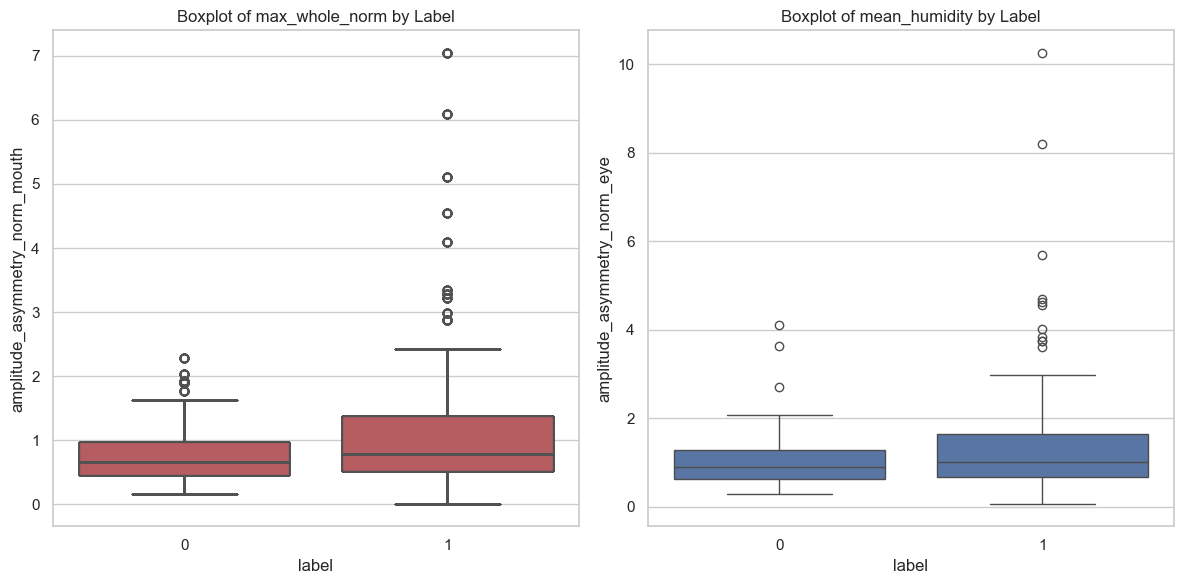

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Creating box and whisker plots to show differences in 'mean_temperature' and 'mean_humidity' between the two groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for key, value in results.items():
    # Plot for 'mean_temperature'
    sns.boxplot(ax=axes[0], x='label', y='amplitude_asymmetry_norm_mouth', data=data)
    axes[0].set_title('Boxplot of max_whole_norm by Label')

# Plot for 'mean_humidity'
sns.boxplot(ax=axes[1], x='label', y='amplitude_asymmetry_norm_eye', data=data)
axes[1].set_title('Boxplot of mean_humidity by Label')

plt.tight_layout()
plt.show()

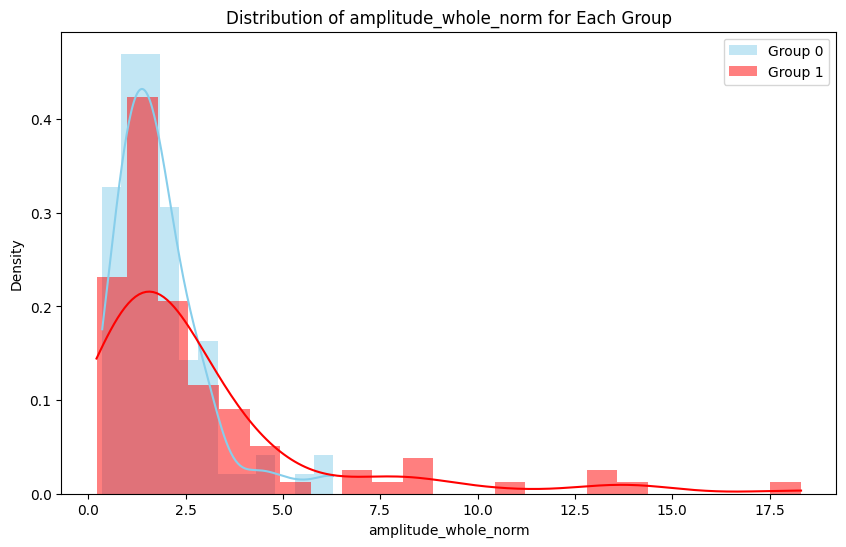

Shapiro-Wilk Test:
Statistic: 0.8476377129554749, P-value: 1.1004786415469425e-08
D'Agostino's K-squared Test:
Statistic: 47.326155210793445, P-value: 5.287568067300083e-11
Skewness: 1.7844915086037403
Kurtosis: 4.092363052827765
At least one test suggests the data may not be normally distributed.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, skew, kurtosis
import numpy as np

# Example column name - replace 'your_column_name' with the actual column name you want to plot
column_name = 'amplitude_whole_norm'

# Creating the figure and axis for the plot
plt.figure(figsize=(10, 6))

# Plotting the distribution for group 0
sns.histplot(data[data['label'] == 0][column_name], color="skyblue", label='Group 0', kde=True, stat="density", linewidth=0)

# Plotting the distribution for group 1
sns.histplot(data[data['label'] == 1][column_name], color="red", label='Group 1', kde=True, stat="density", linewidth=0)

# Adding some plot aesthetics
plt.title(f'Distribution of {column_name} for Each Group')
plt.xlabel(column_name)
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()



# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(data[data['label'] == 0][column_name])
# D'Agostino's K-squared test
dagostino_stat, dagostino_p = normaltest(data[data['label'] == 0][column_name])

# Skewness and Kurtosis
data_skew = skew(data[data['label'] == 0][column_name])
data_kurtosis = kurtosis(data[data['label'] == 0][column_name])

# Results
print(f"Shapiro-Wilk Test:\nStatistic: {shapiro_stat}, P-value: {shapiro_p}")
print(f"D'Agostino's K-squared Test:\nStatistic: {dagostino_stat}, P-value: {dagostino_p}")
print(f"Skewness: {data_skew}\nKurtosis: {data_kurtosis}")

# Interpretation of the results
if shapiro_p > 0.05 and dagostino_p > 0.05:
    print("Both tests suggest the data is normally distributed.")
else:
    print("At least one test suggests the data may not be normally distributed.")

# Note: Interpretation is based on the common alpha level of 0.05. Adjust according to your specific needs.



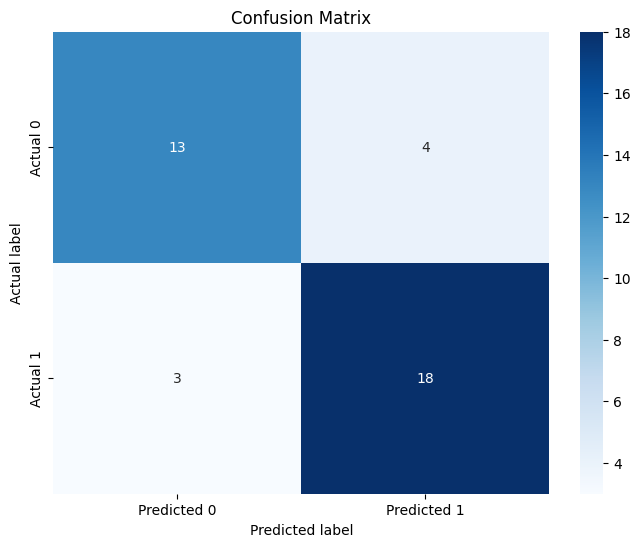

Accuracy: 0.8158
Precision: 0.8182
Recall: 0.8571
F1 Score: 0.8372


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

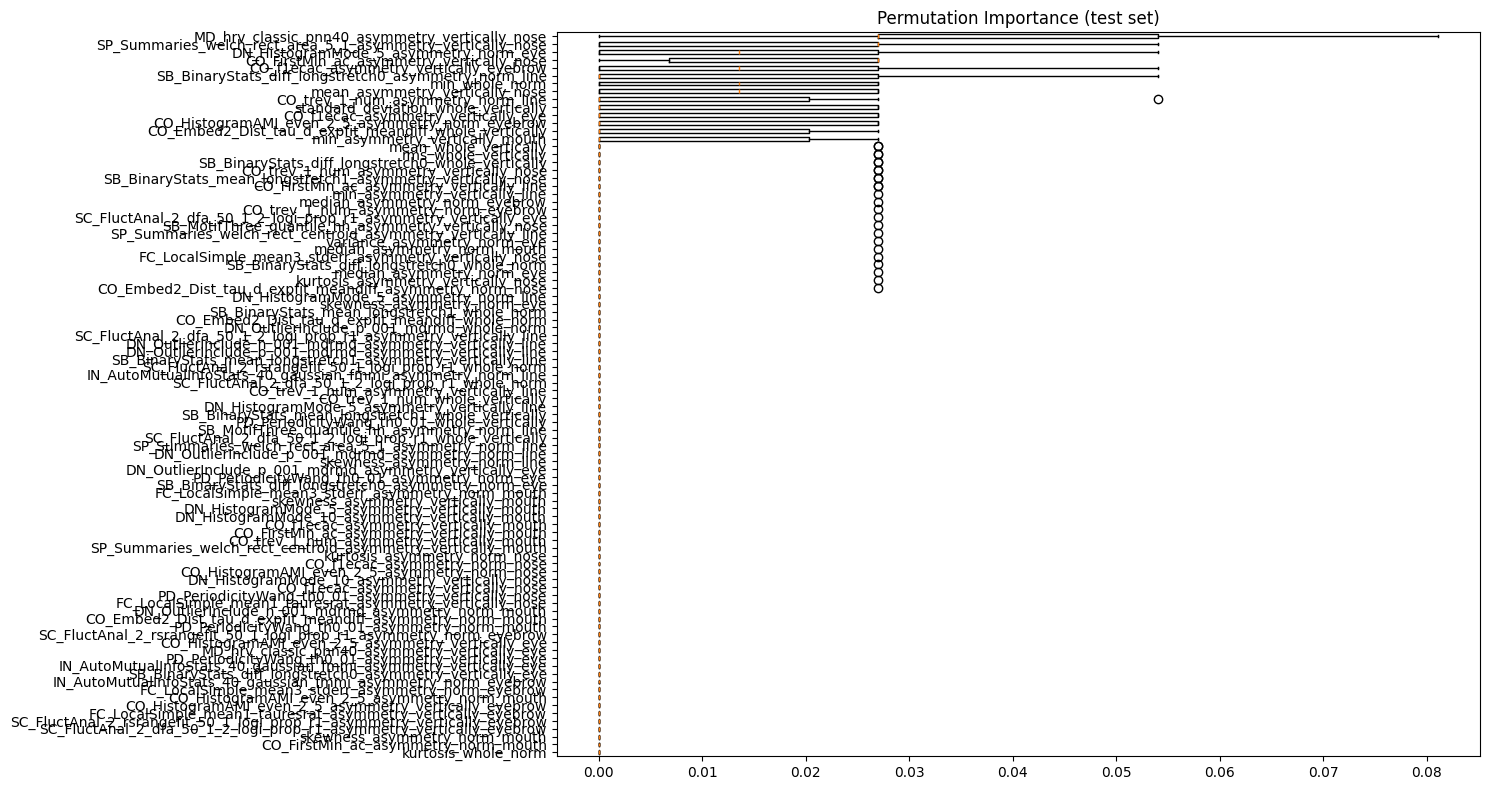

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
# Example: Using the Iris dataset
from sklearn.datasets import load_iris

# Compute permutation feature importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot the importances
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15,8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(selected_feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import MinMaxScaler
from helpers.load_data_subject_csv import  load_data

# Function to normalize dataframes
def normalize_df(df):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)
    return df_normalized

angry_folder = f'./data/working/emotions/angry'
angry_df = load_data(angry_folder, 1)

# happy_folder = f'./data/working/emotions/happy'
# happy_df = load_data(happy_folder, 1)

sad_folder = f'./data/working/emotions/sad'
sad_df = load_data(sad_folder, 1)

disgust_folder = f'./data/working/emotions/disgust'
disgust_df = load_data(disgust_folder, 1)

happy_folder = f'./data/working/emotions/happy'
happy_df = load_data(happy_folder, 1)


dfs = [happy_df, sad_df,angry_df, disgust_df]
means = []
for df in dfs:
    df = df.filter(regex='^max.*norm.*')
    df = normalize_df(df)
    mean = df.mean()
    means.append(mean)
    
    

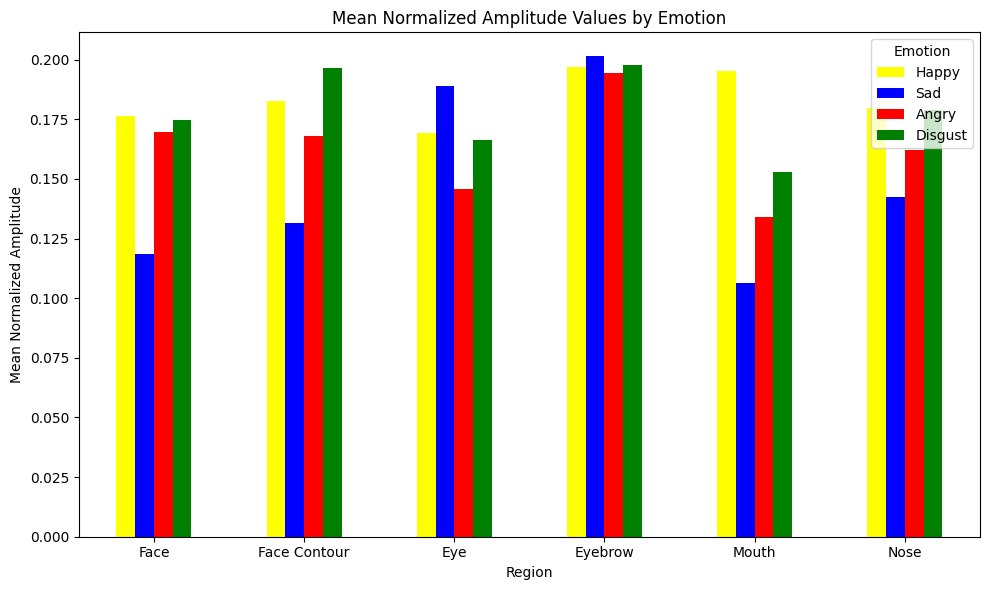

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'means' contains the mean values for each emotion
# Convert the list of Series into a DataFrame
means_df = pd.concat(means, axis=1)


# Transpose the DataFrame for easier plotting
#means_df = means_df

# Plotting
colors = ['yellow','blue','red', 'green']  # Assign a color to each emotion
ax = means_df.plot(kind='bar', figsize=(10, 6),color=colors, xlabel=['face', 'face contoure','eye','eye brow','mouth','nose'])

plt.title('Mean Normalized Amplitude Values by Emotion')
plt.xlabel('Region')
plt.ylabel('Mean Normalized Amplitude')
# Customizing x-axis labels
regions = ['Face', 'Face Contour', 'Eye', 'Eyebrow', 'Mouth', 'Nose']  # Custom labels for each category
ax.set_xticklabels(regions, rotation=0)  # Apply custom labels to x-axis

# Adjusting the legend
plt.legend(loc='upper right', title='Emotion', labels=['Happy','Sad','Angry', 'Disgust'])
plt.tight_layout()
plt.show()


In [125]:
print(means_df.index)

Index(['median_whole_norm', 'median_whole_vertically',
       'median_asymmetry_norm_line', 'median_asymmetry_vertically_line',
       'median_asymmetry_norm_eye', 'median_asymmetry_vertically_eye',
       'median_asymmetry_norm_eyebrow', 'median_asymmetry_vertically_eyebrow',
       'median_asymmetry_norm_mouth', 'median_asymmetry_vertically_mouth',
       'median_asymmetry_norm_nose', 'median_asymmetry_vertically_nose'],
      dtype='object')
